**installation**

In [3]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-aer
!pip install --upgrade qiskit-aer
!pip install qiskit --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

**Necessory imports**

In [4]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator


import numpy as np
from qiskit import transpile
from qiskit.providers.backend import BackendV2 as Backend

**Quantum circuit for 1 layer galton box**

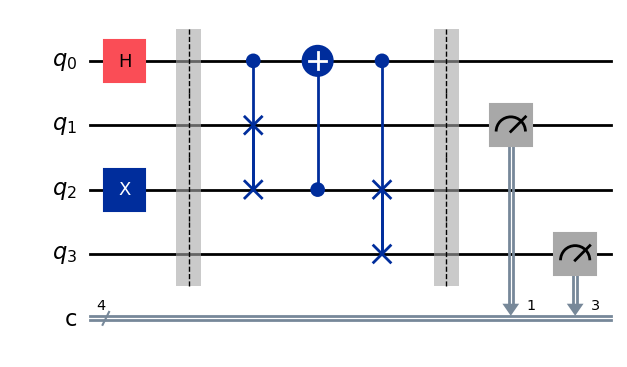

In [5]:
qc = QuantumCircuit(4,4)
qc.h(0)   #creates superposition
qc.x(2)   #act as a ball
qc.barrier()
#peg intiated
qc.cswap(0,1,2)
qc.cx(2,0)
qc.cswap(0,2,3)
qc.barrier()

#measure
qc.measure(1,1)
qc.measure(3,3)

#draw circuit
qc.draw('mpl')

**Run circuit on noiseless simulator**

In [6]:
def simulate_circuit(qc, shots=2048):
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    return counts

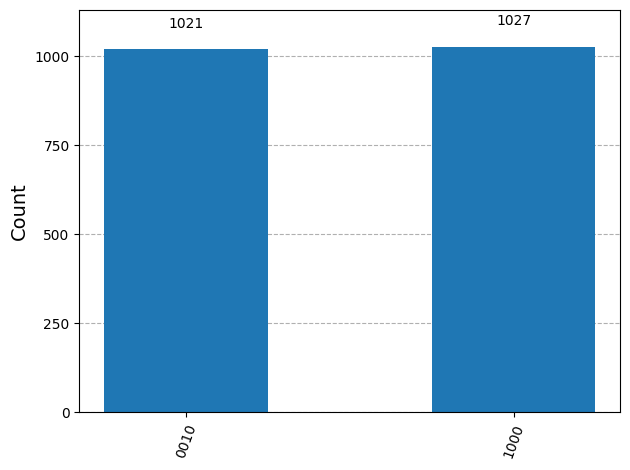

In [7]:
counts = simulate_circuit(qc)
plot_histogram(counts)

**Quantum circuit for 2 layer QGB**

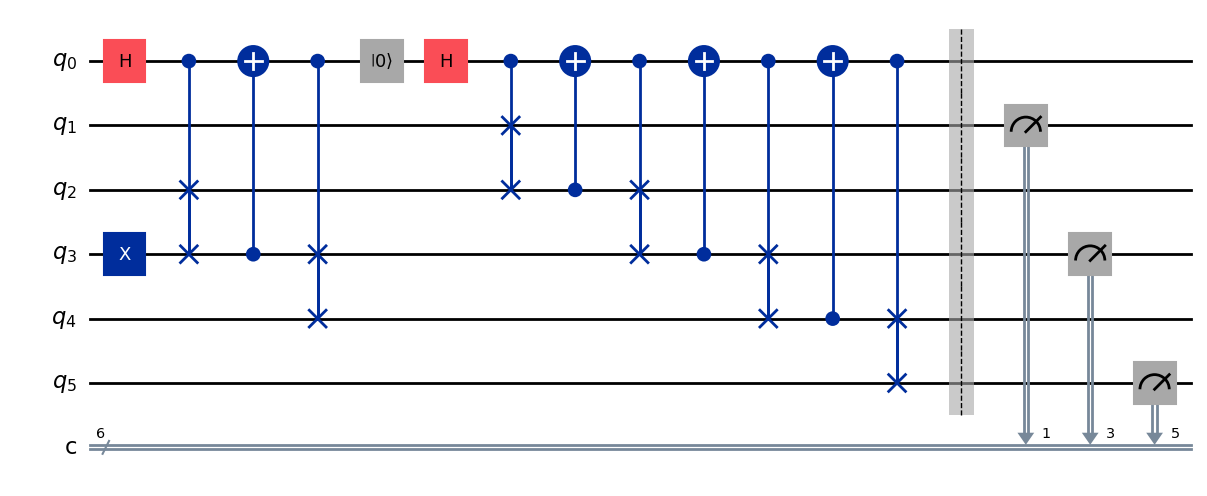

In [8]:
qc = QuantumCircuit(6,6)   #for 2 layer we need 6 qubit
qc.h(0)                    #creates superposition
qc.x(3)                    #act as ball

#1 peg for 1st layer
qc.cswap(0,2,3)
qc.cx(3,0)
qc.cswap(0,3,4)

#reset and apply superposition again
qc.reset(0)
qc.h(0)

#1st peg of 2nd layer

qc.cswap(0,1,2)
qc.cx(2,0)

#2nd peg of 2nd layer
qc.cswap(0,2,3)
qc.cx(3,0)

#3rd peg of 2nd layer
qc.cswap(0,3,4)
qc.cx(4,0)

#------------------
qc.cswap(0,4,5)
#------------------

qc.barrier()


qc.measure(1,1)
qc.measure(3,3)
qc.measure(5,5)


qc.draw('mpl')

**Run on noiseless simulator**

In [9]:
def simulate_circuit(qc, shots=2048):
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    return counts

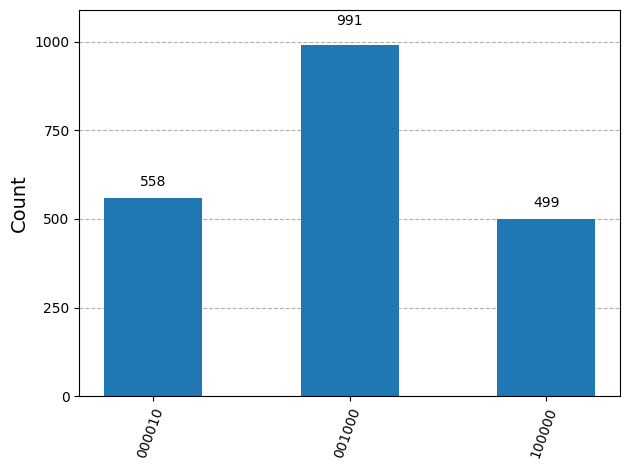

In [10]:
counts = simulate_circuit(qc)
plot_histogram(counts)

**Quantum circuit for N-layer QGB**

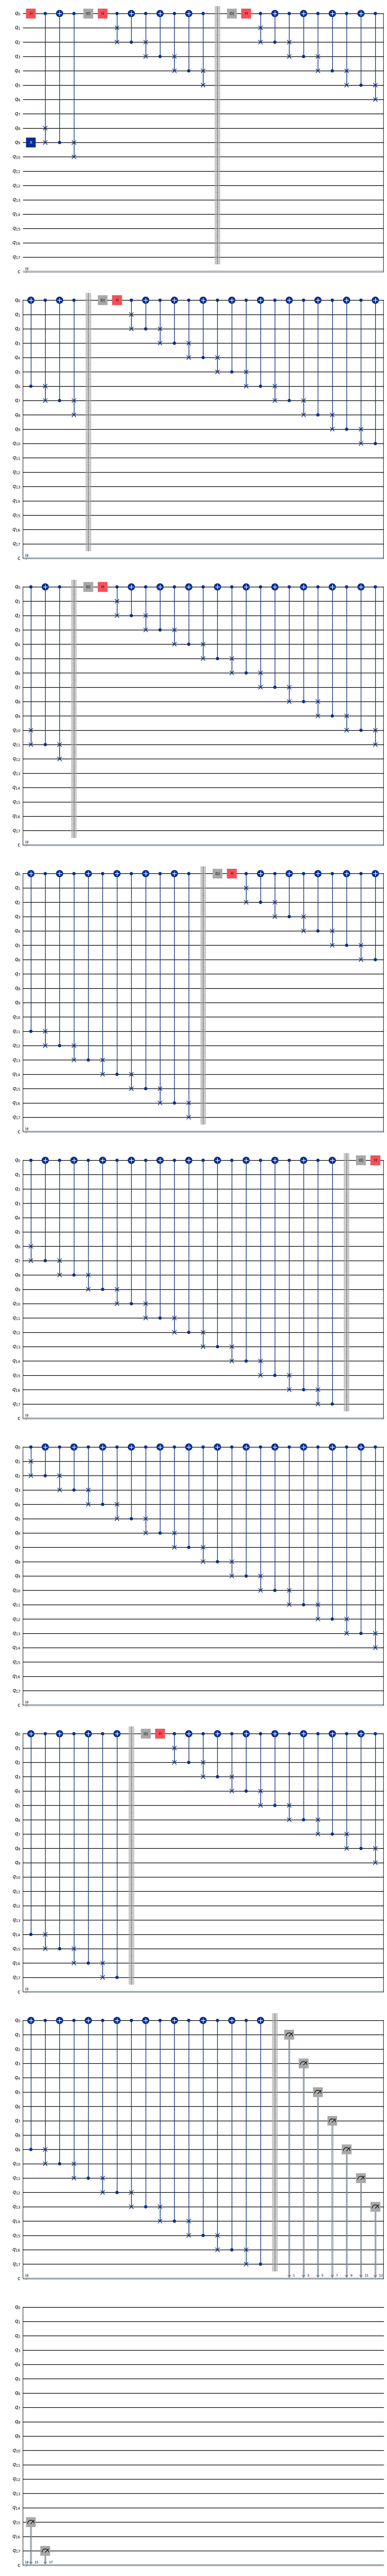

In [11]:
def triangle_number(k):                                               #define triangle number(for pegs in each layer)
    return (k * (k + 1)) // 2


def galton_board(n):
  qc_gaussian = QuantumCircuit(n,n)


  #1st layer of n layer


  qc_gaussian.h(0)                                                            #creates superposition
  qc_gaussian.x(((n-1)//2)+1)                                                 #ball at mid qubit(excluding thee 0th qubit)
  qc_gaussian.cswap(0,((n-1)//2)+1,((n-1)//2))
  qc_gaussian.cx((((n-1)//2)+1),0)
  qc_gaussian.cswap(0,((n-1)//2)+1,(((n-1)//2))+2)

  # Loop for layers 2 to n

  n_Layers = (n-2)//2                          #we take no of qubits = 2 + 2*layer(controll qubit + ball qubit + qubit above and below ball qubit) qubit above and below the ball qubit define the layer


  for count in range(2,n_Layers+1):
    num_operations = triangle_number(count)    #pegs will follow the triangle number in given layer

    qc_gaussian.reset(0)
    qc_gaussian.h(0)
    for op in range(1,num_operations+1):       #cswap
      if op + 1 >= n:
        break
      qc_gaussian.cswap(0,op,op+1)

      if count == n_Layers and op == num_operations+1:      #cx
        continue
      qc_gaussian.cx(op+1, 0)

      if op == num_operations:                           #end cswap
          qc_gaussian.cswap(0, op+1, op+2)

    qc_gaussian.barrier()


  for i in range(1,n):                  #measure at alternative qubits
    if i%2:
      qc_gaussian.measure(i,i)





  return qc_gaussian


'''n=18
(18-2)/2 = 8
 layer = 8'''



qc_gaussian = galton_board(18) #Warning: QBits should always be given in acceptable numbers - 2 + 2*layers
qc_gaussian.draw('mpl')

In [12]:
def simulate_circuit(qc_gaussian, shots=2048):
    simulator = AerSimulator()
    result = simulator.run(qc_gaussian, shots=shots).result()
    counts = result.get_counts()
    return counts

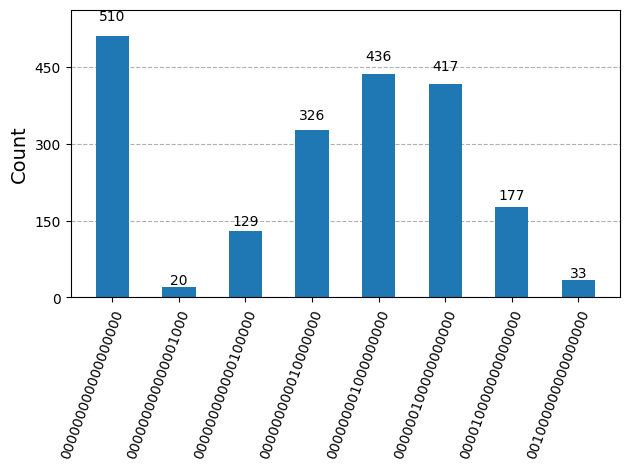

In [13]:
counts = simulate_circuit(qc_gaussian)
plot_histogram(counts)

**Quantum circuit for N layer for exponential graph**

For this we replace the hadamard applied on 0th qubit with Rotaion gate on x-axis with angle pi/4.

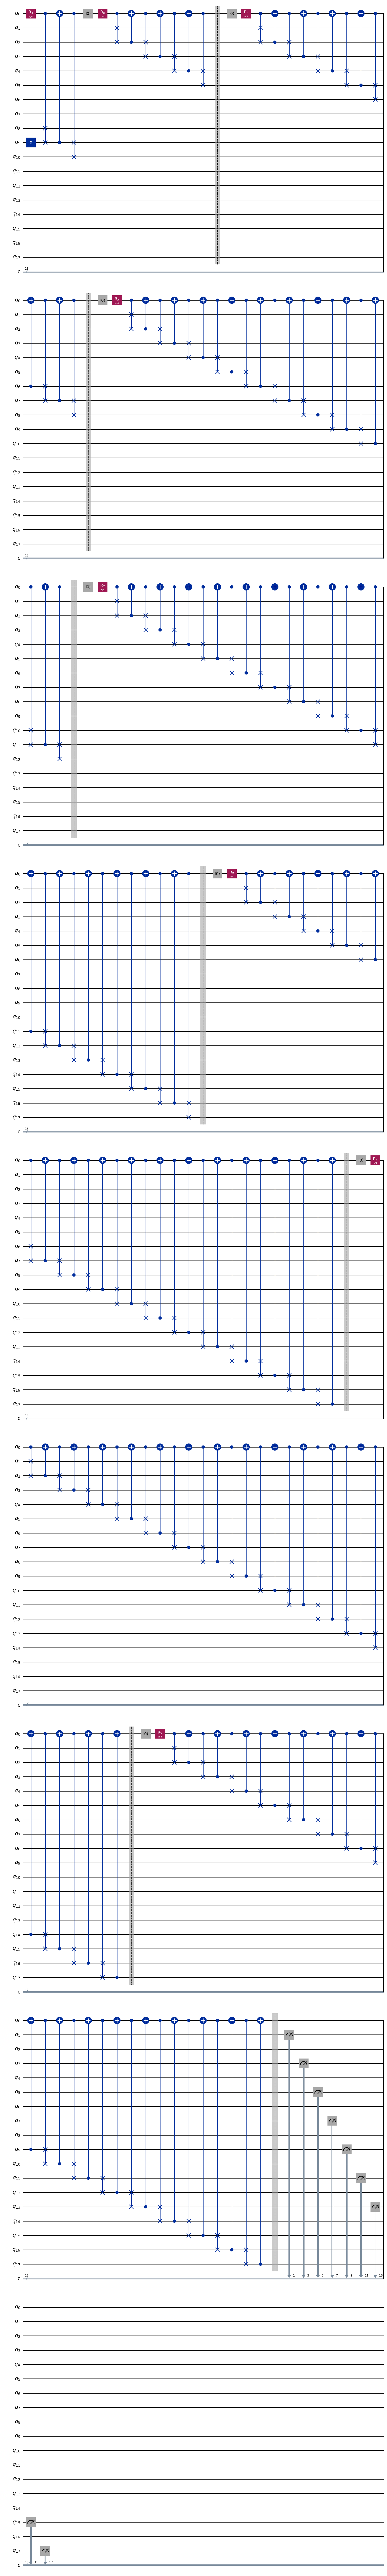

In [14]:
def triangle_number(k):
    return (k * (k + 1)) // 2


def galton_board(n):
  qc_exponential = QuantumCircuit(n,n)


  #1st layer


  qc_exponential.rx((np.pi)/4,0)                                               #Rx gate to create unequal superposition
  qc_exponential.x(((n-1)//2)+1)                                               #ball at mid qubit(excluding 0th qubit)
  qc_exponential.cswap(0,((n-1)//2)+1,((n-1)//2))
  qc_exponential.cx((((n-1)//2)+1),0)
  qc_exponential.cswap(0,((n-1)//2)+1,(((n-1)//2))+2)


  # Loop from count = 2 to n
  n_Layers = (n-2)//2                                              #no of bits = 2 + 2*layers

  for count in range(2,n_Layers+1):
    num_operations = triangle_number(count)

    qc_exponential.reset(0)
    qc_exponential.rx((np.pi)/4,0)                                         #Rx gate to create unequal superposition
    for op in range(1,num_operations+1):
      if op + 1 >= n:
        break
      qc_exponential.cswap(0,op,op+1)

      if count == n_Layers and op == num_operations+1:
        continue
      qc_exponential.cx(op+1, 0)
      if op == num_operations:
          qc_exponential.cswap(0, op+1, op+2)

    qc_exponential.barrier()

  for i in range(1,n):
    if i%2:
      qc_exponential.measure(i,i)





  return qc_exponential




'''n=18
(18-2)/2 = 8
 layer = 8'''

qc_exponential = galton_board(18)               #Warning: QBits should always be given in acceptable numbers - 2 + 2*layers
qc_exponential.draw('mpl')

In [15]:
def simulate_circuit(qc_exponential, shots=2048):
    simulator = AerSimulator()
    result = simulator.run(qc_exponential, shots=shots).result()
    counts = result.get_counts()
    return counts

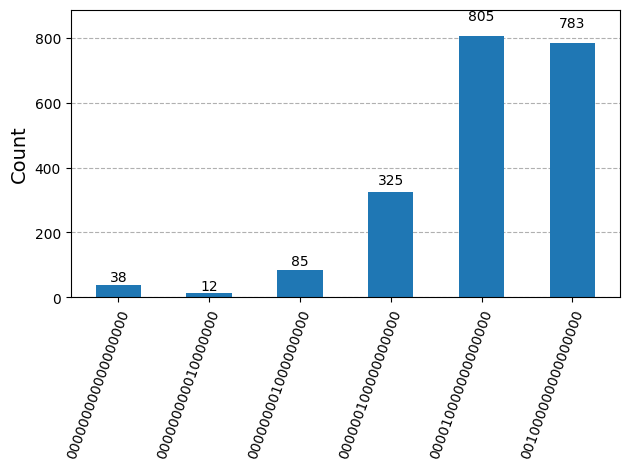

In [16]:
counts = simulate_circuit(qc_exponential)
plot_histogram(counts)

In [17]:
print("Counts:", counts)


Counts: {'000000000010000000': 12, '000000001000000000': 85, '000000000000000000': 38, '000010000000000000': 805, '000000100000000000': 325, '001000000000000000': 783}


**visulisation of exponential distribution**

As we see above we get a nice increasing exponential graph, We can control the inlication by changing the angle of Rotation gates.

Now in next section we compare our grpah with exponential.

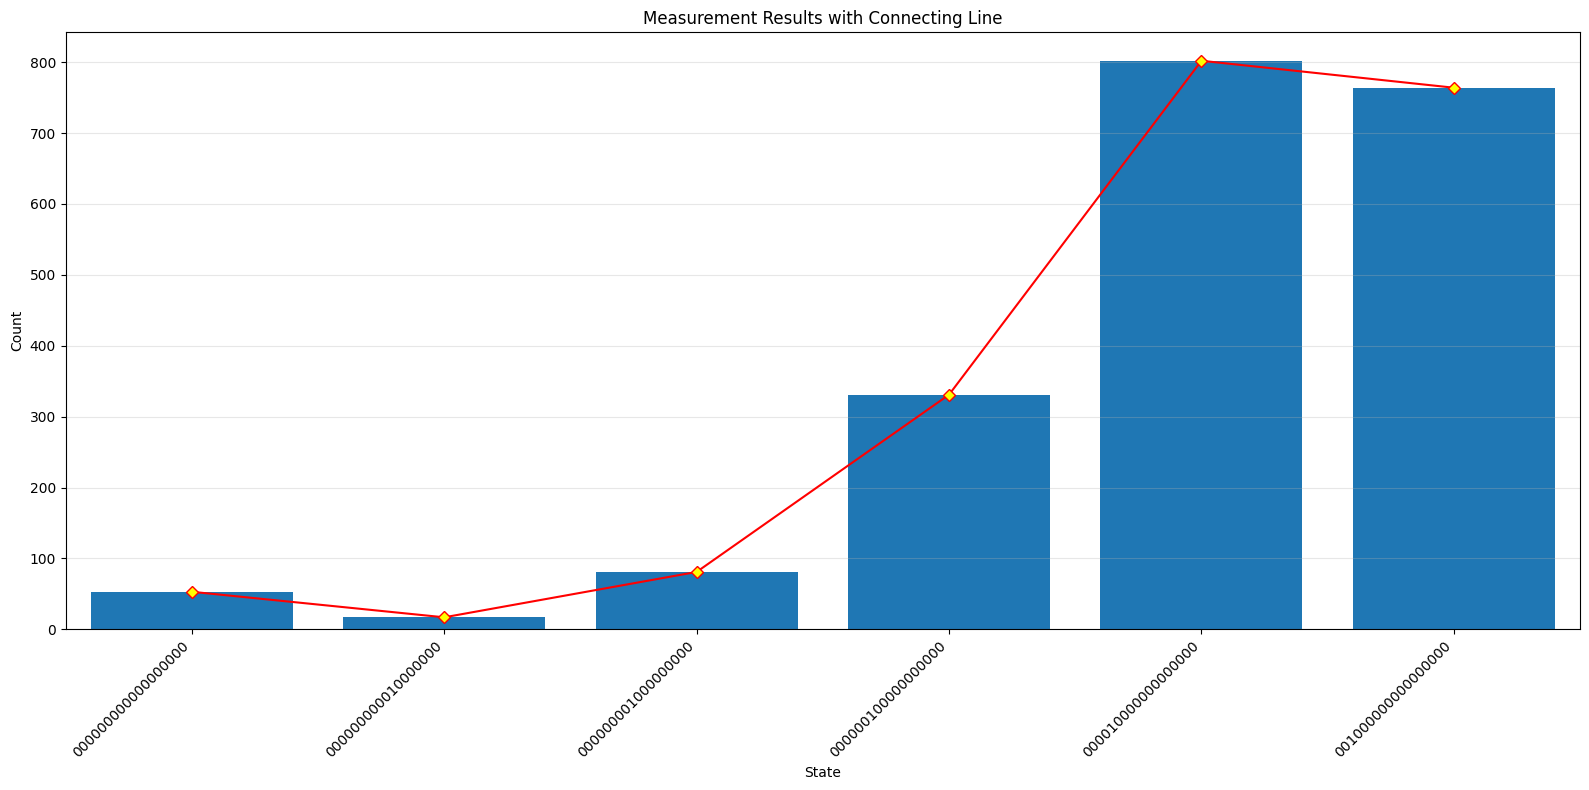

In [18]:
import matplotlib.pyplot as plt

# Assuming your counts data looks like this:
# counts = {'0': 512, '1': 256, '2': 128, ... '193': 104}
counts = simulate_circuit(qc_exponential)  # Your actual counts data

# Convert counts to sorted bitstring states
states = sorted(counts.keys())
values = [counts[k] for k in states]  # Use the original bitstring keys

# Create figure with larger size
plt.figure(figsize=(16, 8))

# Plot bars
bars = plt.bar(states, values, width=0.8)

# Add connecting line to bar tips
x_tips = [bar.get_x() + bar.get_width()/2 for bar in bars]
y_tips = [bar.get_height() for bar in bars]

# Ensure proper line connection by sorting by bitstring (already done in states)
x_sorted = x_tips
y_sorted = y_tips

plt.plot(x_sorted, y_sorted,
         'D-',  # Diamond markers + solid line
         color='red',
         linewidth=1.5,
         markersize=6,
         markerfacecolor='yellow',
         markeredgecolor='red',
         label = "hadamard walk")

# Configure plot
plt.xlabel("State")
plt.ylabel("Count")
plt.title("Measurement Results with Connecting Line")

# Show only every 10th state label to avoid crowding
plt.xticks(states[::max(1, len(states)//10)], rotation=45, ha='right')
plt.xlim(-0.5, len(states) - 0.5) # Adjust x-axis limits
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Quantum circuit for N layer for hadamard walk**

Our intial circuit is built to give output of classical galton board. Controlled swap are applied to trace the ball such that there is no superposirion. Quantum walks on the other hand is built on superposition.

To achive hadamrd walk, I removed all the Controlled swaps and change the controlled qubits of Cnot gate such that it will create superposition.

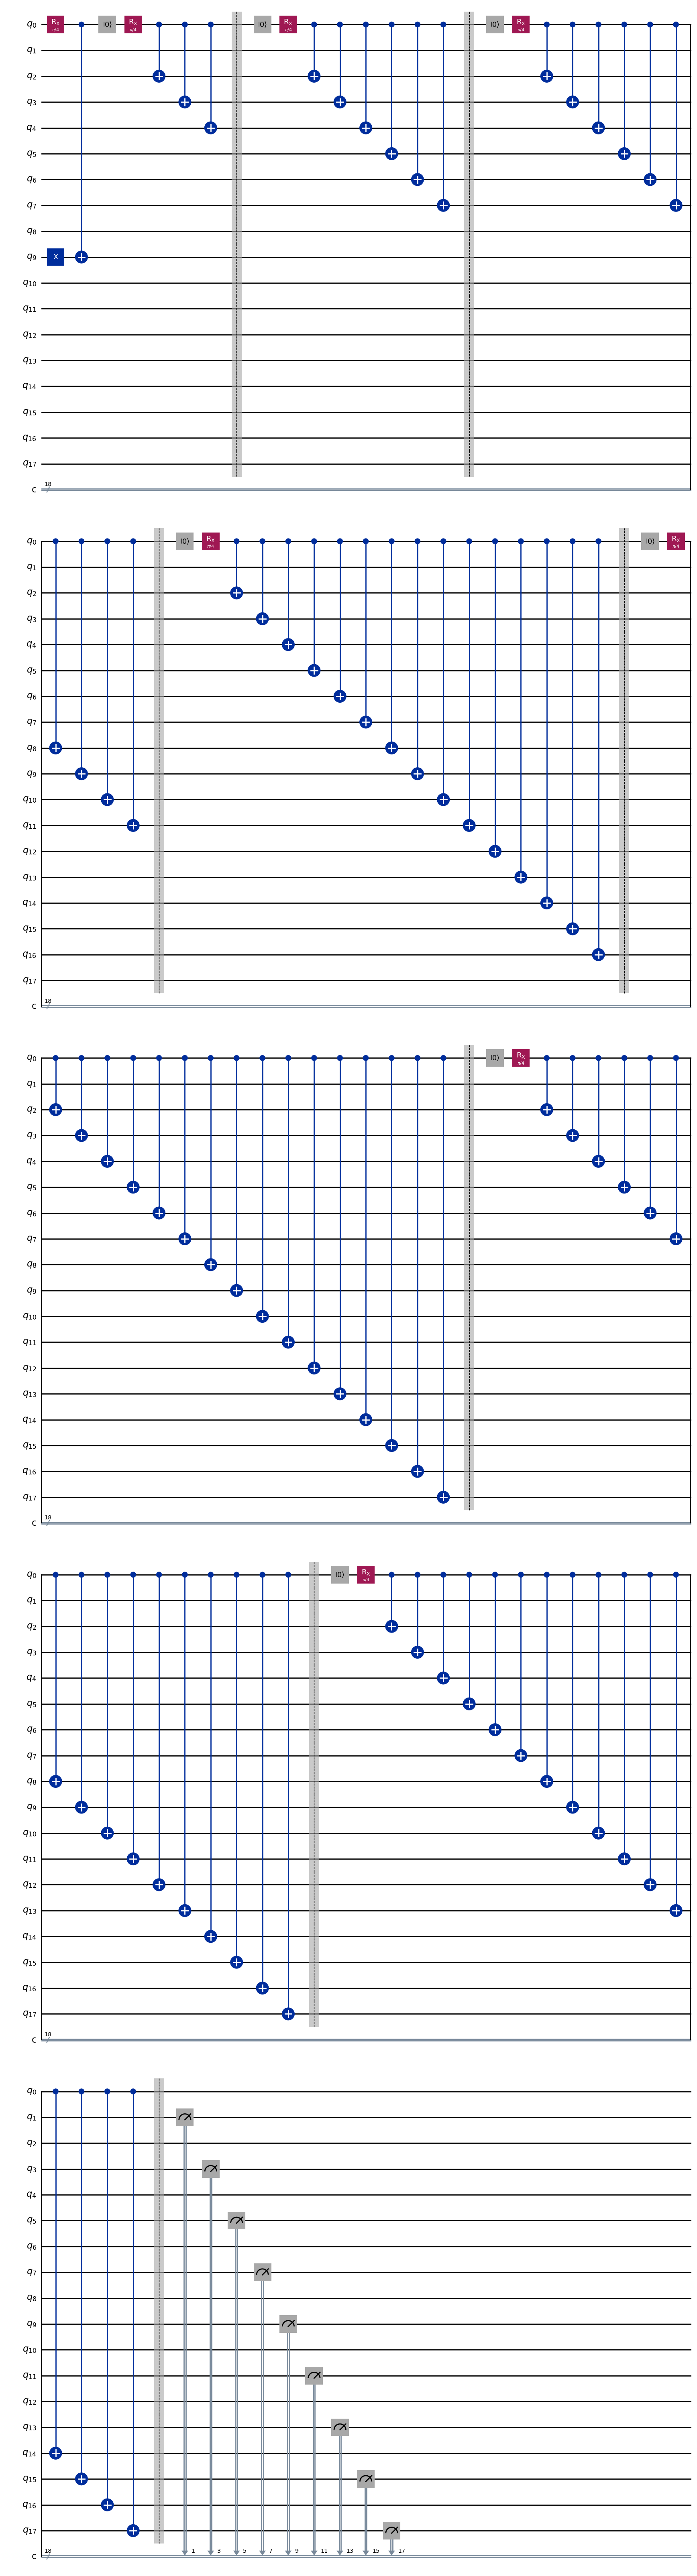

In [19]:
def triangle_number(k):
    return (k * (k + 1)) // 2


def galton_board(n):
  qc_hadamard = QuantumCircuit(n,n)
  #1st layer


  qc_hadamard.rx((np.pi)/4,0)                                                #Rx gate at pi/4 will create equal superposition, it act as hadamard gate
  qc_hadamard.x(((n-1)//2)+1)                                                #ball at mid qubit excludint 0th qubit
  qc_hadamard.cx(0 , (((n-1)//2)+1))

  # Loop from count = 2 to n
  n_Layers = (n-2)//2                                               #since no of bits = 2 + 2*layers


  for count in range(2,n_Layers+1):
    num_operations = triangle_number(count)
    qc_hadamard.reset(0)
    qc_hadamard.rx((np.pi)/4,0)
    for op in range(1,num_operations+1):
      if op + 1 >= n:
        break


      if count == n_Layers and op == num_operations+1:
        continue
      qc_hadamard.cx(0, op+1)
    qc_hadamard.barrier()

  for i in range(1,n):
    if i%2:
      qc_hadamard.measure(i,i)





  return qc_hadamard



'''n=18
(18-2)/2 = 8
 layer = 8'''



qc_hadamard = galton_board(18) #Warning: QBits should always be given in acceptable numbers - 2 + 2*layers
qc_hadamard.draw('mpl')

In [20]:
def simulate_circuit(qc_hadamard, shots=2048):
    simulator = AerSimulator()
    result = simulator.run(qc_hadamard, shots=shots).result()
    counts = result.get_counts()
    return counts

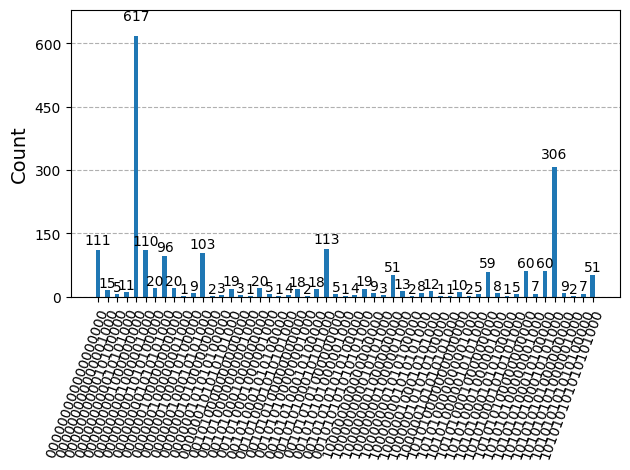

In [21]:
counts = simulate_circuit(qc_hadamard)
plot_histogram(counts)


In [25]:
print('counts:', counts)

counts: {'100000100000000000': 1, '000000000010100000': 2, '000000101000000000': 4, '000000100000001000': 1, '001010100000001000': 2, '001010001000001000': 1, '101010101000000000': 8, '101010000000000000': 12, '100000000000000000': 9, '101010001010101000': 7, '100000001010100000': 3, '101010100000001000': 8, '101010001000001000': 12, '101010101000001000': 1, '001010100010101000': 104, '000000001010101000': 101, '101010001000000000': 52, '100000000010101000': 2, '101010100010101000': 324, '001010001010100000': 2, '100000001000000000': 42, '100000000010100000': 1, '001010000000000000': 5, '000000001010100000': 19, '000000001000000000': 598, '000000000000000000': 112, '101010101010100000': 10, '100000001010101000': 15, '001010001010101000': 5, '101010000010101000': 1, '000000100010101000': 119, '000000001000001000': 119, '001010100010100000': 22, '100000100010101000': 6, '101010101010101000': 49, '101010100000000000': 60, '001010101000000000': 7, '001010101000001000': 1, '0000001000101000

**Visualisation of hadamard walk**

As we can see, we get desirable hadamard walk with some abnormality at |000000000000000>. The hadamard walk distribution we get is more spread out distribution and show lower bound around origin. It shows asymmetry.

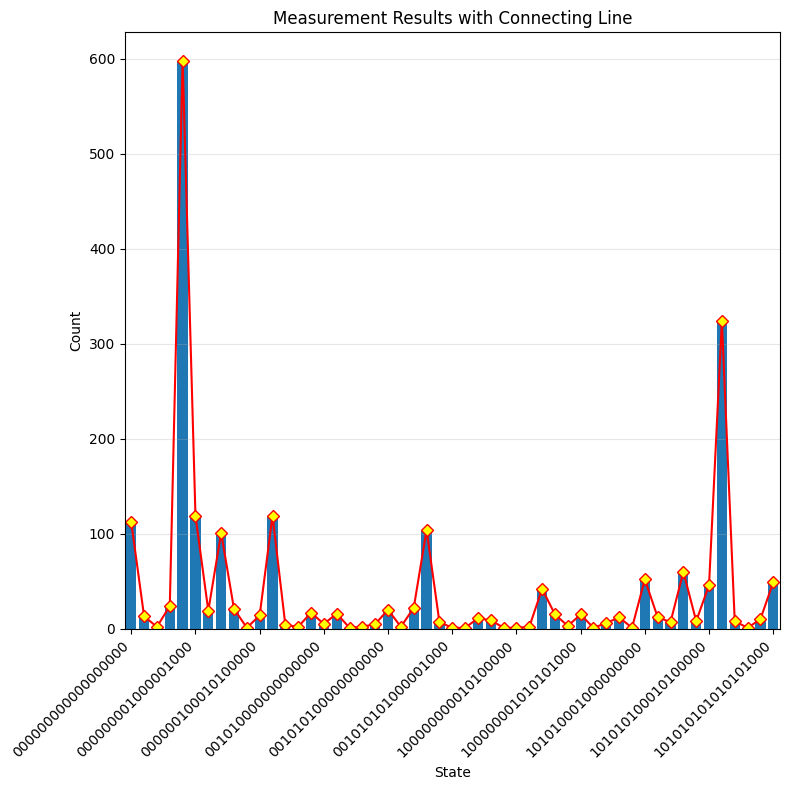

In [23]:
import matplotlib.pyplot as plt

# Assuming your counts data looks like this:
# counts = {'0': 512, '1': 256, '2': 128, ... '193': 104}
counts = simulate_circuit(qc_hadamard)  # Your actual counts data

# Convert counts to sorted bitstring states
states = sorted(counts.keys())
values = [counts[k] for k in states]  # Use the original bitstring keys

# Create figure with larger size
plt.figure(figsize=(8, 8))

# Plot bars
bars = plt.bar(states, values, width=0.8)

# Add connecting line to bar tips
x_tips = [bar.get_x() + bar.get_width()/2 for bar in bars]
y_tips = [bar.get_height() for bar in bars]

# Ensure proper line connection by sorting by bitstring (already done in states)
x_sorted = x_tips
y_sorted = y_tips

plt.plot(x_sorted, y_sorted,
         'D-',  # Diamond markers + solid line
         color='red',
         linewidth=1.5,
         markersize=6,
         markerfacecolor='yellow',
         markeredgecolor='red',
         label = "hadamard walk")

# Configure plot
plt.xlabel("State")
plt.ylabel("Count")
plt.title("Measurement Results with Connecting Line")

# Show only every 10th state label to avoid crowding
plt.xticks(states[::max(1, len(states)//10)], rotation=45, ha='right')
plt.xlim(-0.5, len(states) - 0.5) # Adjust x-axis limits
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()